## Ustawienie hardware

In [1]:
import torch
import random
import numpy as np
import gym
import warnings

# Ustawienia dla reprodukowalności
SEED = 42

OPTIMIZE_WITH_HARDWARE = True

device = torch.device('cpu')
if OPTIMIZE_WITH_HARDWARE:
    if torch.backends.mps.is_available():
        device = torch.device('mps')
        print(f'Wybrano urządzenie: MPS')
    elif torch.cuda.is_available():
        device = torch.device('cuda')
        print(f'Wybrano urządzenie: GPU z obsługą CUDA')
        print(f'Nazwa urządzenia CUDA: {torch.cuda.get_device_name()}')
        print(f'Liczba urządzeń CUDA: {torch.cuda.device_count()}')
        print(f'Indeks urządzenia CUDA: {torch.cuda.current_device()}')
else:
    print(f'Wybrano urządzenie: CPU')

# Ustawienie ziaren losowych
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)


warnings.filterwarnings("ignore")


Wybrano urządzenie: GPU z obsługą CUDA
Nazwa urządzenia CUDA: Quadro M1200
Liczba urządzeń CUDA: 1
Indeks urządzenia CUDA: 0


## Ogólne przedstawienie problemu

In [2]:
# Inicjalizacja środowiska
env = gym.make("LunarLander-v2")
env.action_space.seed(SEED)
env.observation_space.seed(SEED)

state = env.reset()
if isinstance(state, tuple):
    state = state[0]

terminated = False
truncated = False

while not (terminated or truncated):
    action = env.action_space.sample()  # Losowa akcja
    result = env.step(action)
    if len(result) == 5:
        next_state, reward, terminated, truncated, info = result
        done = terminated or truncated
    else:
        next_state, reward, done, info = result
    env.render()
    if done:
        break

env.close()


## Co zwraca środowisko?

Stan - wektor opisujący aktualne położenie i dynamikę lądownika.

- pozycja pozioma lądownika (x);
- pozycja pionowa lądownika (y)
- prędkość pozioma lądownika
- prędkość pionowa lądownika
- kąt nachylenia lądownika
- prędkość kątowa lądownika
- czy noga nr 1 (lewa) lądownika dotyka podłoża
- czy noga nr 2 (prawa) lądownika dotyka podłoża

## Ile akcji może wykonać agent?

In [3]:
print(f'Ilość możliwych akcji: {env.action_space.n}')

Ilość możliwych akcji: 4


1. Brak działania
2. Uruchomiony główny silnik
3. Uruchomiony lewy silnik
4. Uruchomiony prawy silnik

## Hiperparametry

In [4]:
# Hiperparametry
BATCH_SIZE = 64
LEARNING_RATE = 1e-4
GAMMA = 0.99  # Współczynnik dyskontowania przyszłych nagród
EPSILON_START = 1.0  # Początkowa wartość współczynnika eksploracji
EPSILON_MIN = 0.01
EPSILON_DECAY = 0.995  # Współczynnik zmniejszania wartości epsilon (na epizod)
MEMORY_SIZE = 100000  # Maksymalny rozmiar pamięci przechowującej przejścia
TRAIN_START = 1000  # Rozpoczęcie uczenia po zebraniu danej liczby doświadczeń
TARGET_UPDATE_STEPS = 1000  # Aktualizacja sieci docelowej co określoną liczbę kroków
MAX_EPISODES = 500
MAX_STEPS = 1000  # Maksymalna liczba kroków w epizodzie
# Hiperparametry do przetestowania
learning_rates = [1e-3, 1e-4, 1e-5]
discount_factors = [0.9, 0.95, 0.99]
epsilon_decays = [0.99910, 0.99941, 0.99954, 0.99973, 0.99987]

# Liczba epizodów
EPISODES = 300

## Zaimportowanie niezbędnych bibliotek

In [5]:
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns


## Struktura sieci głębokiej

In [6]:
class DQNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  # Warstwa wejściowa
        self.fc2 = nn.Linear(256, 256)        # Warstwa ukryta
        self.fc3 = nn.Linear(256, output_size)  # Warstwa wyjściowa

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        q_values = self.fc3(x)  # Q-wartości dla każdej akcji
        return q_values


## Definicja agenta sieci DQN

In [7]:
class DQNAgent:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.epsilon = EPSILON_START
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.model = DQNetwork(input_size, output_size).to(device)
        self.target_model = DQNetwork(input_size, output_size).to(device)
        self.update_target_model()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=LEARNING_RATE)
        self.loss_function = nn.SmoothL1Loss()
        self.total_steps = 0

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.output_size)
        state = torch.FloatTensor(state).to(device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state)
            return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < TRAIN_START:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.FloatTensor(states).to(device)
        actions = torch.LongTensor(actions).unsqueeze(1).to(device)
        rewards = torch.FloatTensor(rewards).unsqueeze(1).to(device)
        next_states = torch.FloatTensor(next_states).to(device)
        dones = torch.FloatTensor(dones).unsqueeze(1).to(device)

        q_values = self.model(states).gather(1, actions)

        # Double DQN
        next_actions = self.model(next_states).argmax(1).unsqueeze(1)
        next_q_values = self.target_model(next_states).gather(1, next_actions).detach()

        target_q_values = rewards + (GAMMA * next_q_values * (1 - dones))

        loss = self.loss_function(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()

        # Obcinanie gradientów
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

        self.optimizer.step()

        self.total_steps += 1
        if self.total_steps % TARGET_UPDATE_STEPS == 0:
            self.update_target_model()

    def decay_epsilon(self):
        if self.epsilon > EPSILON_MIN:
            self.epsilon *= EPSILON_DECAY
        else:
            self.epsilon = EPSILON_MIN
    

## Definicja pętli treningowej modelu

In [8]:
# Definicja pętli treningowej modelu
import warnings
warnings.filterwarnings('ignore')

env = gym.make("LunarLander-v2")
env.action_space.seed(SEED)
env.observation_space.seed(SEED)
input_size = env.observation_space.shape[0]
output_size = env.action_space.n
agent = DQNAgent(input_size, output_size)


episodes = MAX_EPISODES
rewards_history = []
total_steps = 0

# Grid search dla różnych wartości hyperparametrów
results = []

for alpha in learning_rates:
    for gamma in discount_factors:
        for epsilon_decay in epsilon_decays:
            # Kod dla treningu agenta
            agent = DQNAgent(input_size, output_size)
            agent.optimizer = torch.optim.Adam(agent.model.parameters(), lr=alpha)
            agent.gamma = gamma
            agent.epsilon_decay = epsilon_decay

            rewards_history = []

            for episode in range(EPISODES):  # Liczba epizodów
                state = env.reset()
                if isinstance(state, tuple):
                    state = state[0]
                total_reward = 0
                done = False

                while not done:
                    action = agent.act(state)
                    result = env.step(action)
                    if len(result) == 5:
                        next_state, reward, terminated, truncated, info = result
                        done = terminated or truncated
                    else:
                        next_state, reward, done, info = result

                    agent.memorize(state, action, reward, next_state, done)
                    agent.replay()
                    state = next_state
                    total_reward += reward

                agent.decay_epsilon()
                rewards_history.append(total_reward)

            # Zapisz wyniki dla tej kombinacji hyperparametrów
            results.append({
                'alpha': alpha,
                'gamma': gamma,
                'epsilon_decay': epsilon_decay,
                'rewards': rewards_history
            })
# Grupowanie danych dla różnych epsilon_decay
epsilon_decay_results = {}
for result in results:
    key = result['epsilon_decay']
    if key not in epsilon_decay_results:
        epsilon_decay_results[key] = []
    epsilon_decay_results[key].append(result['rewards'])

# Grupowanie danych dla learning rate i gamma
learning_rate_gamma_results = {}
for result in results:
    key = (result['alpha'], result['gamma'])
    if key not in learning_rate_gamma_results:
        learning_rate_gamma_results[key] = []
    learning_rate_gamma_results[key].append(result['rewards'])

# Zapis wyników do pliku JSON
import json

with open('results1.json', 'w') as f:
    json.dump(results, f)



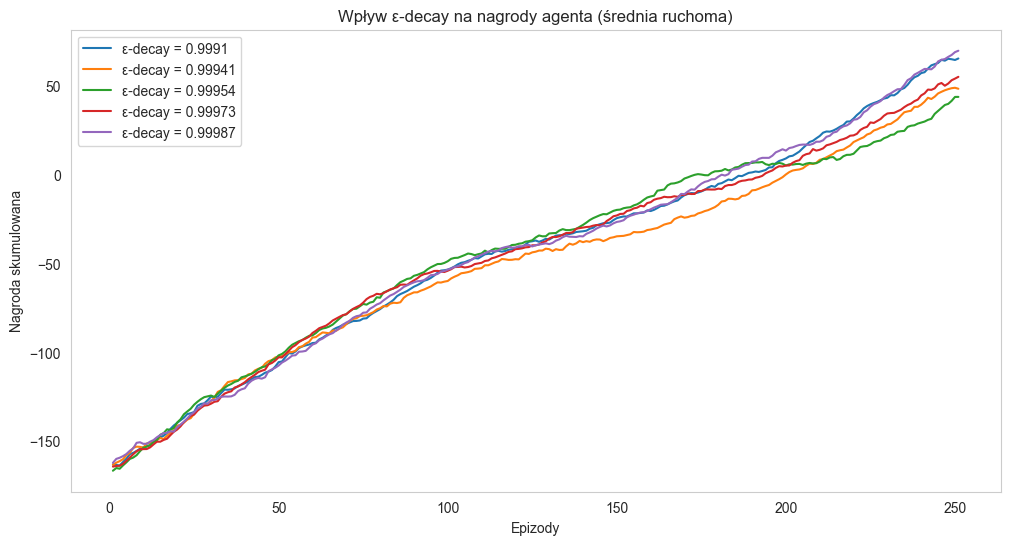

In [19]:
def moving_average(data, window_size=10):
    """Oblicza średnią ruchomą z danych."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')
episodes = range(1, EPISODES + 1)

# Parametr okna średniej ruchomej
window_size = 50

plt.figure(figsize=(12, 6))
for epsilon_decay, rewards_list in epsilon_decay_results.items():
    # Obliczenie średniej nagród i zastosowanie średniej ruchomej
    mean_rewards = np.mean(rewards_list, axis=0)  # Średnia nagród dla danego epsilon_decay
    smoothed_rewards = moving_average(mean_rewards, window_size)
    smoothed_episodes = range(1, len(smoothed_rewards) + 1)  # Dopasowanie epizodów

    # Rysowanie wygładzonej linii
    plt.plot(smoothed_episodes, smoothed_rewards, label=f'ε-decay = {epsilon_decay}')

plt.title('Wpływ ε-decay na nagrody agenta (średnia ruchoma)')
plt.xlabel('Epizody')
plt.ylabel('Nagroda skumulowana')
plt.legend()
plt.grid()
plt.show()




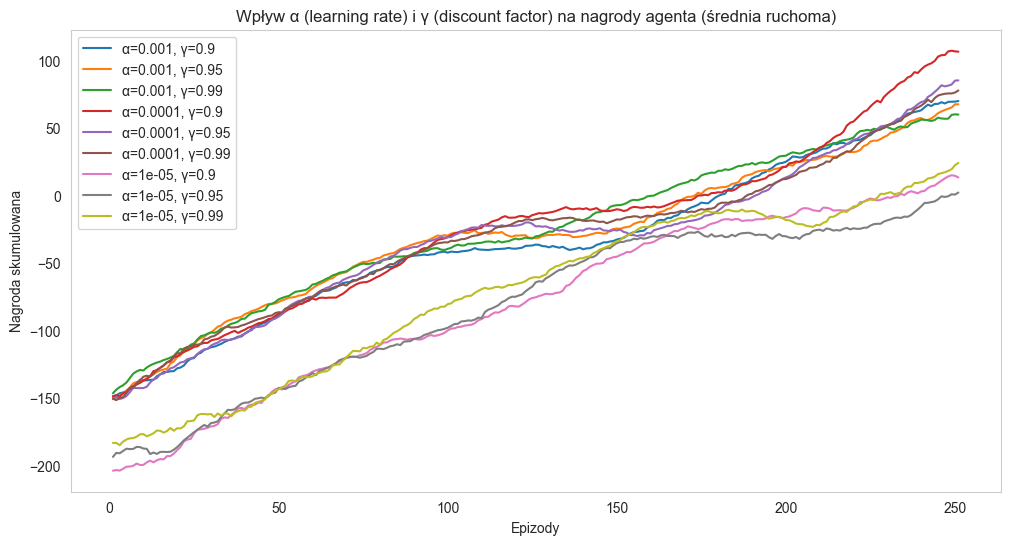

In [18]:
# Parametr okna średniej ruchomej
window_size = 50

plt.figure(figsize=(12, 6))
for (alpha, gamma), rewards_list in learning_rate_gamma_results.items():
    # Obliczenie średniej nagród
    mean_rewards = np.mean(rewards_list, axis=0)
    
    # Zastosowanie średniej ruchomej
    smoothed_rewards = moving_average(mean_rewards, window_size)
    smoothed_episodes = range(1, len(smoothed_rewards) + 1)  # Dopasowanie epizodów

    # Rysowanie wykresu
    plt.plot(smoothed_episodes, smoothed_rewards, label=f'α={alpha}, γ={gamma}')

plt.title('Wpływ α (learning rate) i γ (discount factor) na nagrody agenta (średnia ruchoma)')
plt.xlabel('Epizody')
plt.ylabel('Nagroda skumulowana')
plt.legend()
plt.grid()
plt.show()


## Wykresy

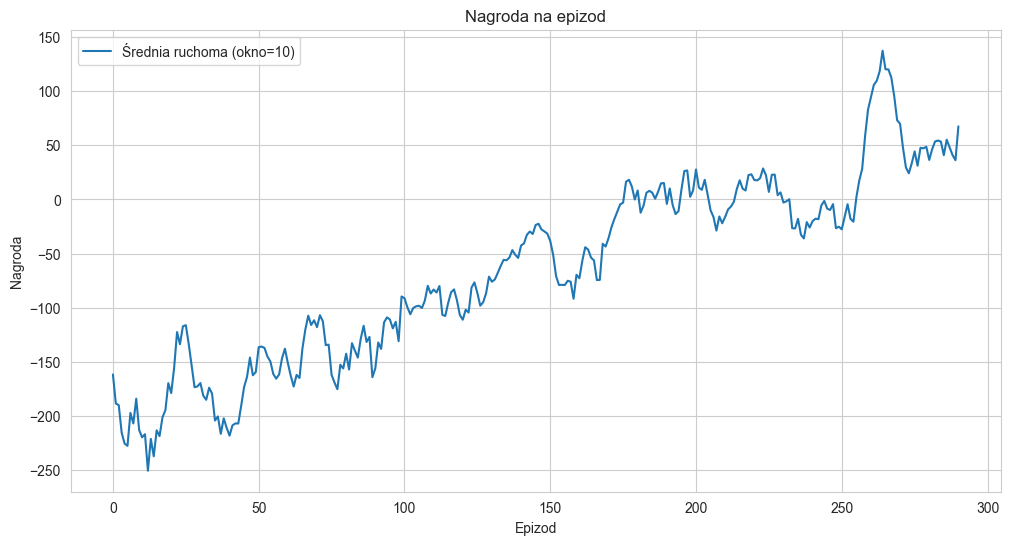

In [21]:
# Wykresy
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("whitegrid")

window_size = 10
moving_avg = np.convolve(rewards_history, np.ones(window_size)/window_size, mode='valid')
x = np.arange(len(moving_avg))

plt.figure(figsize=(12,6))
plt.plot(x, moving_avg, label=f"Średnia ruchoma (okno={window_size})")
plt.title("Nagroda na epizod")
plt.xlabel("Epizod")
plt.ylabel("Nagroda")
plt.legend()
plt.show()


## Testowanie modelu

In [ ]:
'''# Testowanie modelu

# Inicjalizacja urządzenia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Stwórz środowisko
env = gym.make('LunarLander-v2', render_mode='human')
env.action_space.seed(SEED)
env.observation_space.seed(SEED)
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

# Załaduj wytrenowany model
model = DQNetwork(input_size, output_size).to(device)
checkpoint = torch.load('dqn_lunar_lander.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Ustaw epsilon na zero (choć nie jest używany podczas testowania)
epsilon = 0.0

# Testuj model
for episode in range(5):
    state = env.reset()
    if isinstance(state, tuple):
        state = state[0]
    total_reward = 0
    done = False
    while not done:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = model(state_tensor)
        action = torch.argmax(q_values).item()
        result = env.step(action)
        if len(result) == 5:
            next_state, reward, terminated, truncated, info = result
            done = terminated or truncated
        else:
            next_state, reward, done, info = result
        state = next_state
        total_reward += reward
        env.render()
    print(f'Epizod {episode + 1}: Łączna nagroda: {total_reward:.2f}')
env.close()'''


"# Testowanie modelu\n\n# Inicjalizacja urządzenia\ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')\n\n# Stwórz środowisko\nenv = gym.make('LunarLander-v2', render_mode='human')\nenv.action_space.seed(SEED)\nenv.observation_space.seed(SEED)\ninput_size = env.observation_space.shape[0]\noutput_size = env.action_space.n\n\n# Załaduj wytrenowany model\nmodel = DQNetwork(input_size, output_size).to(device)\ncheckpoint = torch.load('dqn_lunar_lander.pth', map_location=device)\nmodel.load_state_dict(checkpoint['model_state_dict'])\nmodel.eval()\n\n# Ustaw epsilon na zero (choć nie jest używany podczas testowania)\nepsilon = 0.0\n\n# Testuj model\nfor episode in range(5):\n    state = env.reset()\n    if isinstance(state, tuple):\n        state = state[0]\n    total_reward = 0\n    done = False\n    while not done:\n        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)\n        with torch.no_grad():\n            q_values = model(state_tensor)\n        a

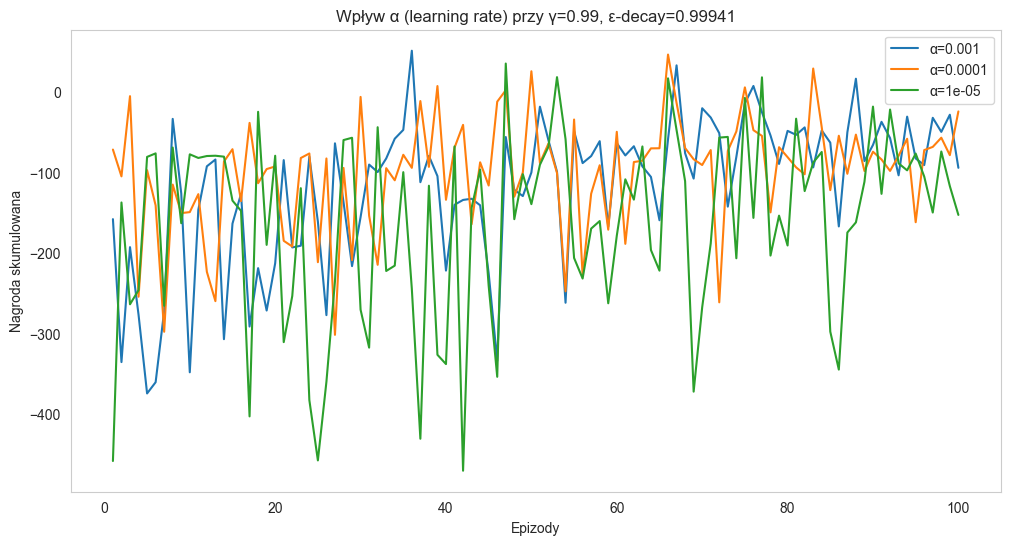

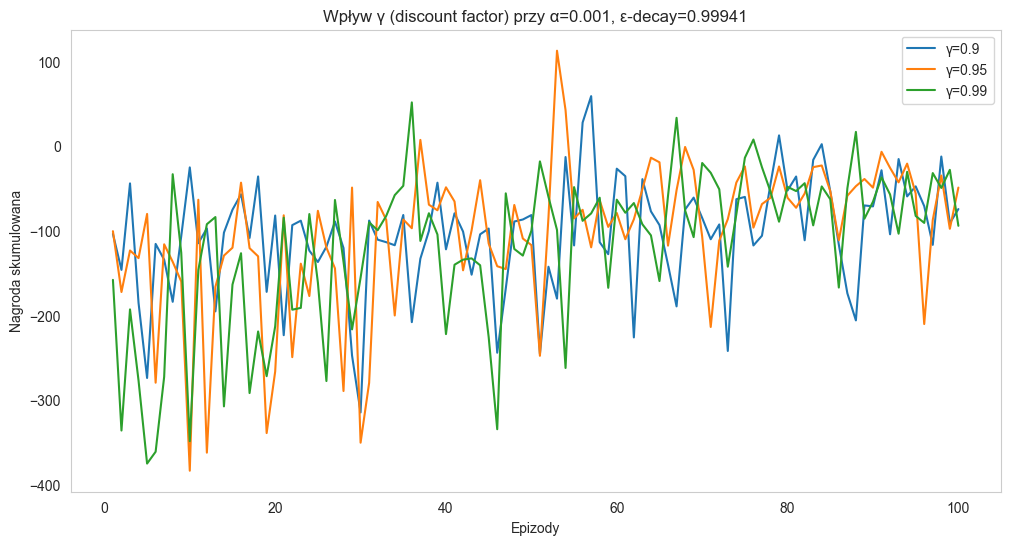

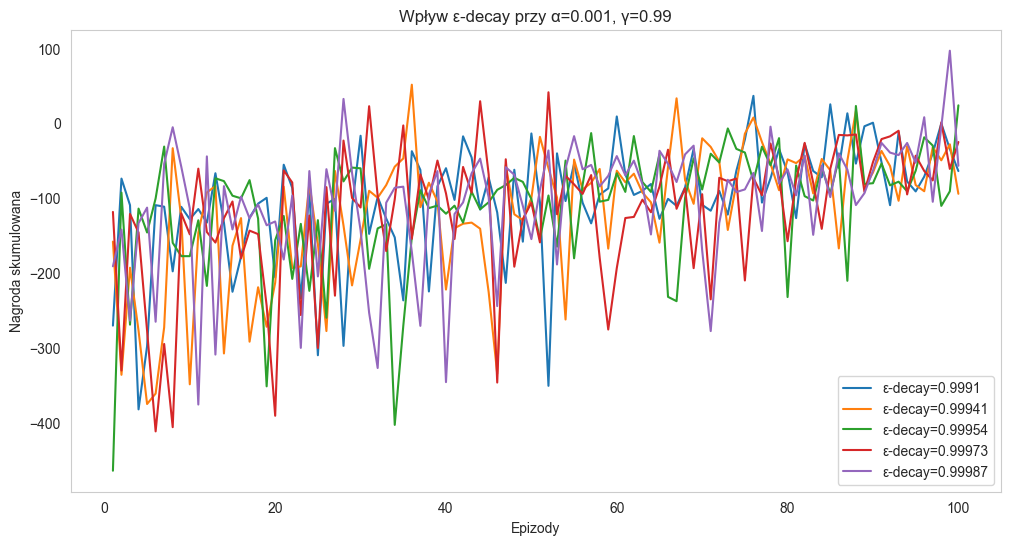

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Funkcja obliczająca średnie nagrody na epizod
def calculate_mean_rewards(results, key, fixed_params):
    grouped_data = {}
    for result in results:
        if all(result[k] == v for k, v in fixed_params.items()):
            param_value = result[key]
            if param_value not in grouped_data:
                grouped_data[param_value] = []
            grouped_data[param_value].append(result['rewards'])
    mean_rewards = {k: np.mean(np.array(v), axis=0) for k, v in grouped_data.items()}
    return mean_rewards

# Epizody
EPISODES = 100
episodes = range(1, EPISODES + 1)

# Wykres 1: Zmiana α przy stałym γ i ε-decay
gamma_fixed = 0.99
epsilon_decay_fixed = 0.99941
alpha_rewards = calculate_mean_rewards(results, 'alpha', {'gamma': gamma_fixed, 'epsilon_decay': epsilon_decay_fixed})

plt.figure(figsize=(12, 6))
for alpha, rewards in alpha_rewards.items():
    plt.plot(episodes, rewards[:EPISODES], label=f'α={alpha}')
plt.title(f'Wpływ α (learning rate) przy γ={gamma_fixed}, ε-decay={epsilon_decay_fixed}')
plt.xlabel('Epizody')
plt.ylabel('Nagroda skumulowana')
plt.legend()
plt.grid()
plt.show()

# Wykres 2: Zmiana γ przy stałym α i ε-decay
alpha_fixed = 0.001
gamma_rewards = calculate_mean_rewards(results, 'gamma', {'alpha': alpha_fixed, 'epsilon_decay': epsilon_decay_fixed})

plt.figure(figsize=(12, 6))
for gamma, rewards in gamma_rewards.items():
    plt.plot(episodes, rewards[:EPISODES], label=f'γ={gamma}')
plt.title(f'Wpływ γ (discount factor) przy α={alpha_fixed}, ε-decay={epsilon_decay_fixed}')
plt.xlabel('Epizody')
plt.ylabel('Nagroda skumulowana')
plt.legend()
plt.grid()
plt.show()

# Wykres 3: Zmiana ε-decay przy stałym α i γ
epsilon_rewards = calculate_mean_rewards(results, 'epsilon_decay', {'alpha': alpha_fixed, 'gamma': gamma_fixed})

plt.figure(figsize=(12, 6))
for epsilon_decay, rewards in epsilon_rewards.items():
    plt.plot(episodes, rewards[:EPISODES], label=f'ε-decay={epsilon_decay}')
plt.title(f'Wpływ ε-decay przy α={alpha_fixed}, γ={gamma_fixed}')
plt.xlabel('Epizody')
plt.ylabel('Nagroda skumulowana')
plt.legend()
plt.grid()
plt.show()
